In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
df = pd.read_csv("twitter_bots_final.csv")

In [3]:
df['account_type'].value_counts(normalize=True)

human    0.668118
bot      0.331882
Name: account_type, dtype: float64

In [4]:
# drop unnecessary columns
df1 = df.drop(columns=['description_en', 'description'])

# define feature groups 
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols = ['lang', 'description_language']
num_cols = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]
target_col = 'account_type'

# convert target to binary
df1[target_col] = df1[target_col].map({'human': 0, 'bot': 1})

# split train/val/test 80/10/10
train_df1, temp_df1 = train_test_split(df1, test_size=0.2, stratify=df1[target_col], random_state=42)
val_df1, test_df1 = train_test_split(temp_df1, test_size=0.5, stratify=temp_df1[target_col], random_state=42)

print("Train:", train_df1.shape)
print("Val:", val_df1.shape)
print("Test:", test_df1.shape)

# boolean to int
train_df1[bool_cols] = train_df1[bool_cols].astype(int)
val_df1[bool_cols] = val_df1[bool_cols].astype(int)
test_df1[bool_cols] = test_df1[bool_cols].astype(int)

# one-hot encode categorical columns
train_df1 = pd.get_dummies(train_df1, columns=cat_cols, drop_first=True)

# ensure val/test have the same columns as train
val_df1 = pd.get_dummies(val_df1, columns=cat_cols, drop_first=True)
val_df1 = val_df1.reindex(columns=train_df1.columns, fill_value=0)

test_df1 = pd.get_dummies(test_df1, columns=cat_cols, drop_first=True)
test_df1 = test_df1.reindex(columns=train_df1.columns, fill_value=0)

# scale numerical features
scaler = StandardScaler()
train_df1[num_cols] = scaler.fit_transform(train_df1[num_cols])
val_df1[num_cols] = scaler.transform(val_df1[num_cols])
test_df1[num_cols] = scaler.transform(test_df1[num_cols])

# convert embeddings into arrays
def str_to_array(s):
    s = s.strip("[]")
    return np.array(s.split(), dtype=float)

train_df1['description_en_embeddings'] = train_df1['description_en_embeddings'].apply(str_to_array)
val_df1['description_en_embeddings'] = val_df1['description_en_embeddings'].apply(str_to_array)
test_df1['description_en_embeddings'] = test_df1['description_en_embeddings'].apply(str_to_array)

X_train_embed = np.vstack(train_df1['description_en_embeddings'].values)
X_val_embed   = np.vstack(val_df1['description_en_embeddings'].values)
X_test_embed  = np.vstack(test_df1['description_en_embeddings'].values)

# combine embeddings with tabular features
feature_cols = [c for c in train_df1.columns if c not in ['description_en_embeddings', target_col]]
X_train_tabular = train_df1[feature_cols].values
X_val_tabular   = val_df1[feature_cols].values
X_test_tabular  = test_df1[feature_cols].values

X_train = np.hstack([X_train_embed, X_train_tabular])
X_val   = np.hstack([X_val_embed, X_val_tabular])
X_test  = np.hstack([X_test_embed, X_test_tabular])

y_train = train_df1[target_col].values
y_val   = val_df1[target_col].values
y_test  = test_df1[target_col].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


Train: (29950, 19)
Val: (3744, 19)
Test: (3744, 19)
X_train shape: (29950, 574)
X_val shape: (3744, 574)
X_test shape: (3744, 574)


In [5]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


## Train all features without reducing dimensions

In [6]:
# define models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None, class_weight='balanced', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight='balanced', random_state=42
    )
}

# train and evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # train
    model.fit(X_train, y_train)
    
    # validation
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    print("Validation Metrics:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("AUC:", roc_auc_score(y_val, y_val_prob))
    print(classification_report(y_val, y_val_pred))
    
    # test
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    print("Test Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("AUC:", roc_auc_score(y_test, y_test_prob))
    print(classification_report(y_test, y_test_pred))



===== Logistic Regression =====
Validation Metrics:
Accuracy: 0.7729700854700855
AUC: 0.865164473229212
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      2501
           1       0.62      0.81      0.70      1243

    accuracy                           0.77      3744
   macro avg       0.76      0.78      0.76      3744
weighted avg       0.80      0.77      0.78      3744

Test Metrics:
Accuracy: 0.7553418803418803
AUC: 0.8504890129764144
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      2502
           1       0.60      0.79      0.68      1242

    accuracy                           0.76      3744
   macro avg       0.74      0.76      0.74      3744
weighted avg       0.78      0.76      0.76      3744


===== Decision Tree =====
Validation Metrics:
Accuracy: 0.8197115384615384
AUC: 0.7938329093141505
              precision    recall  f1-score   support

           0       

## Train features without embeddings

In [7]:
# define models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None, class_weight='balanced', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight='balanced', random_state=42
    )
}

# train and evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # train
    model.fit(X_train_tabular, y_train)
    
    # validation
    y_val_pred = model.predict(X_val_tabular)
    y_val_prob = model.predict_proba(X_val_tabular)[:, 1]
    print("Validation Metrics:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("AUC:", roc_auc_score(y_val, y_val_prob))
    print(classification_report(y_val, y_val_pred))
    
    # test
    y_test_pred = model.predict(X_test_tabular)
    y_test_prob = model.predict_proba(X_test_tabular)[:, 1]
    print("Test Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("AUC:", roc_auc_score(y_test, y_test_prob))
    print(classification_report(y_test, y_test_pred))


===== Logistic Regression =====
Validation Metrics:
Accuracy: 0.7580128205128205
AUC: 0.8460258696199718
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      2501
           1       0.60      0.81      0.69      1243

    accuracy                           0.76      3744
   macro avg       0.74      0.77      0.75      3744
weighted avg       0.79      0.76      0.76      3744

Test Metrics:
Accuracy: 0.7427884615384616
AUC: 0.8352068747578428
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      2502
           1       0.58      0.81      0.68      1242

    accuracy                           0.74      3744
   macro avg       0.73      0.76      0.73      3744
weighted avg       0.78      0.74      0.75      3744


===== Decision Tree =====
Validation Metrics:
Accuracy: 0.8325320512820513
AUC: 0.811320041573073
              precision    recall  f1-score   support

           0       

## Use model1 to reduce embeddings into a probability score

In [8]:
# use logreg for model1
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight to handle imbalance
model1.fit(X_train_embed, y_train)

# predict probabilities
train_prob = model1.predict_proba(X_train_embed)[:, 1]
val_prob   = model1.predict_proba(X_val_embed)[:, 1]
test_prob  = model1.predict_proba(X_test_embed)[:, 1]

# check performance on validation set
y_val_pred = model1.predict(X_val_embed)
y_val_prob = val_prob

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))

# add model1 probability as a new column to your tabular features
X_train_model2 = np.hstack([train_prob.reshape(-1, 1), X_train_tabular])
X_val_model2   = np.hstack([val_prob.reshape(-1, 1), X_val_tabular])
X_test_model2  = np.hstack([test_prob.reshape(-1, 1), X_test_tabular])

print("X_train_model2 shape:", X_train_model2.shape)
print("X_val_model2 shape:", X_val_model2.shape)
print("X_test_model2 shape:", X_test_model2.shape)

Validation Accuracy: 0.6728098290598291
Validation AUC: 0.7587108358587378
              precision    recall  f1-score   support

           0       0.85      0.62      0.72      2501
           1       0.50      0.79      0.61      1243

    accuracy                           0.67      3744
   macro avg       0.68      0.70      0.67      3744
weighted avg       0.74      0.67      0.68      3744

X_train_model2 shape: (29950, 191)
X_val_model2 shape: (3744, 191)
X_test_model2 shape: (3744, 191)


try rf for model1

In [9]:
# use randomforest for model1
model1_tree = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # no limit on depth; you can tune this
    class_weight='balanced', # handle class imbalance
    random_state=42
)

# train on embeddings
model1_tree.fit(X_train_embed, y_train)

# predict probabilities
train_prob_tree = model1_tree.predict_proba(X_train_embed)[:, 1]
val_prob_tree   = model1_tree.predict_proba(X_val_embed)[:, 1]
test_prob_tree  = model1_tree.predict_proba(X_test_embed)[:, 1]

# evaluate on validation set 
y_val_pred_tree = model1_tree.predict(X_val_embed)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_tree))
print("Validation AUC:", roc_auc_score(y_val, val_prob_tree))
print(classification_report(y_val, y_val_pred_tree))

# combine probability scores with tabular features for model2
X_train_model2_tree = np.hstack([train_prob_tree.reshape(-1, 1), X_train_tabular])
X_val_model2_tree   = np.hstack([val_prob_tree.reshape(-1, 1), X_val_tabular])
X_test_model2_tree  = np.hstack([test_prob_tree.reshape(-1, 1), X_test_tabular])

print("X_train_model2_tree shape:", X_train_model2_tree.shape)

Validation Accuracy: 0.6917735042735043
Validation AUC: 0.7448623125166667
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2501
           1       0.53      0.62      0.57      1243

    accuracy                           0.69      3744
   macro avg       0.66      0.67      0.67      3744
weighted avg       0.71      0.69      0.70      3744

X_train_model2_tree shape: (29950, 191)


performance dont seem as good as lr

model2 = logistic regression

In [10]:
# initialise model2 using logistic regression
model2_lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# train on training set
model2_lr.fit(X_train_model2, y_train)

# predict on validation
y_val_pred = model2_lr.predict(X_val_model2)
y_val_prob = model2_lr.predict_proba(X_val_model2)[:, 1]

# evaluate
print("LR Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("LR Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))


LR Validation Accuracy: 0.7775106837606838
LR Validation ROC-AUC: 0.864760451410747
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      2501
           1       0.63      0.81      0.71      1243

    accuracy                           0.78      3744
   macro avg       0.76      0.79      0.76      3744
weighted avg       0.80      0.78      0.78      3744



In [ ]:
# predict on test set
y_test_pred = model2_lr.predict(X_test_model2)
y_test_prob = model2_lr.predict_proba(X_test_model2)[:, 1]

print("LR Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("LR Test AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))

LR Test Accuracy: 0.7537393162393162
LR Test AUC: 0.8475676785463737
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2502
           1       0.60      0.78      0.68      1242

    accuracy                           0.75      3744
   macro avg       0.74      0.76      0.74      3744
weighted avg       0.78      0.75      0.76      3744



model2 = decision tree

In [ ]:
# initialise model2 using decision tree
model2_dt = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)
model2_dt.fit(X_train_model2, y_train)

# predict on validation set 
y_val_pred = model2_dt.predict(X_val_model2)
y_val_prob = model2_dt.predict_proba(X_val_model2)[:, 1]

print("DT Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("DT Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))

DT Validation Accuracy: 0.8354700854700855
DT Validation ROC-AUC: 0.8127098315943132
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2501
           1       0.76      0.74      0.75      1243

    accuracy                           0.84      3744
   macro avg       0.82      0.81      0.81      3744
weighted avg       0.83      0.84      0.84      3744



In [ ]:
# predict on test set 
y_test_pred = model2_dt.predict(X_test_model2)
y_test_prob = model2_dt.predict_proba(X_test_model2)[:, 1]

print("DT Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("DT Test ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))

DT Test Accuracy: 0.8226495726495726
DT Test ROC-AUC: 0.797564846673386
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2502
           1       0.74      0.72      0.73      1242

    accuracy                           0.82      3744
   macro avg       0.80      0.80      0.80      3744
weighted avg       0.82      0.82      0.82      3744



model2 = random forest 

In [ ]:
# initialise model2 using random forest
model2_rf = RandomForestClassifier(n_estimators=200, max_depth=None, class_weight='balanced', random_state=42)
model2_rf.fit(X_train_model2, y_train)

# predict on validation set 
y_val_pred = model2_rf.predict(X_val_model2)
y_val_prob = model2_rf.predict_proba(X_val_model2)[:, 1]

print("RF Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("RF Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))

RF Validation Accuracy: 0.8739316239316239
RF Validation ROC-AUC: 0.9371889216960038
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2501
           1       0.87      0.72      0.79      1243

    accuracy                           0.87      3744
   macro avg       0.87      0.84      0.85      3744
weighted avg       0.87      0.87      0.87      3744



In [ ]:
# predict on test set
y_test_pred = model2_rf.predict(X_test_model2)
y_test_prob = model2_rf.predict_proba(X_test_model2)[:, 1]

print("RF Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("RF Test ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))

RF Test Accuracy: 0.8656517094017094
RF Test ROC-AUC: 0.928300837590797
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2502
           1       0.85      0.72      0.78      1242

    accuracy                           0.87      3744
   macro avg       0.86      0.83      0.84      3744
weighted avg       0.86      0.87      0.86      3744



## BERTopic

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
import umap
import matplotlib.pyplot as plt
import shap

In [ ]:
# Count empty or missing description_en
empty_count = df['description_en'].isna().sum() + (df['description_en'].str.strip() == '').sum()

print(f"Number of empty or missing descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")

Number of empty or missing descriptions: 13341
Percentage of total: 35.63%


Empty descriptions: 13341
Percentage of total: 35.63%


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitl


Train Topic Proportions (%):
-1     32.57
 0     35.53
 1      6.44
 2      3.72
 3      2.91
 4      2.60
 5      2.38
 6      2.09
 7      2.08
 8      1.97
 9      1.91
 10     1.90
 11     1.05
 12     0.86
 13     0.63
 14     0.52
 15     0.17
 16     0.17
 17     0.11
 18     0.10
 19     0.08
 20     0.07
 21     0.05
 22     0.04
 23     0.04
Name: topic, dtype: float64


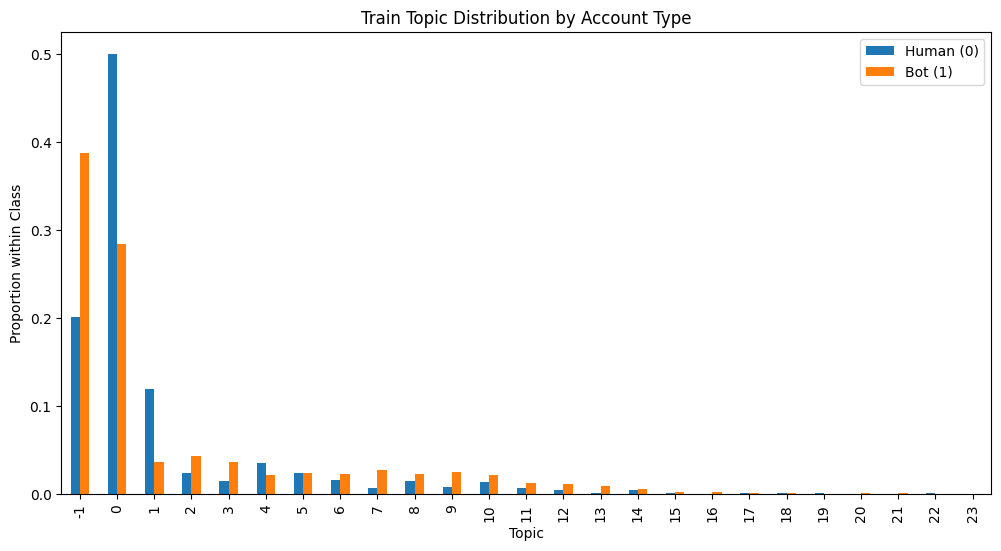


Top Topics:
   Topic  Count                                               Name  \
0     -1   9755                             -1_love_life_im_writer   
1      0  10641  0_missing_description_missing_description miss...   
2      1   1929                            1_twitter_like_come_bot   
3      2   1114                      2_music_actor_producer_dancer   
4      3    873                          3_husband_father_mom_wife   
5      4    780          4_trading_stock_trading stock_day trading   
6      5    714                            5_love_life_dream_world   
7      6    625                  6_translationtext_im_ive_im sorry   
8      7    622                 7_news_podcast_reporter_journalist   
9      8    591                 8_photographer_designer_artist_art   

                                      Representation  \
0  [love, life, im, writer, lover, mom, author, f...   
1  [missing_description, missing_description miss...   
2  [twitter, like, come, bot, want, tweet, accou

In [ ]:
# drop unused columns 
df_bert = df.drop(columns=['description', 'description_en_embeddings']).copy()

# check empty descriptions
empty_count = df_bert['description_en'].isna().sum()
print(f"Empty descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")

# replace empty descriptions with placeholder
df_bert['description_en'] = df_bert['description_en'].fillna("missing_description")

# train/val/test 80/10/10
train_df, temp_df = train_test_split(df_bert, test_size=0.2, stratify=df_bert['account_type'], random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['account_type'], random_state=42)

# tabular features
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols  = ['lang', 'description_language']
num_cols  = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]

# booleans to int
for col in bool_cols:
    train_df[col] = train_df[col].astype(int)
    val_df[col]   = val_df[col].astype(int)
    test_df[col]  = test_df[col].astype(int)

# one-hot encode categoricals
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
val_df   = pd.get_dummies(val_df, columns=cat_cols, drop_first=True)
val_df   = val_df.reindex(columns=train_df.columns, fill_value=0)
test_df  = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)
test_df  = test_df.reindex(columns=train_df.columns, fill_value=0)

# scale numeric features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
val_df[num_cols]   = scaler.transform(val_df[num_cols])
test_df[num_cols]  = scaler.transform(test_df[num_cols])

# define BERTopic model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # English

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words='english')

nr_topics = 25

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",
    nr_topics=nr_topics,
    top_n_words=10
)

# fit BERTopic model on train set 
train_texts = train_df['description_en'].tolist()
topics_train, probs_train = topic_model.fit_transform(train_texts)

# transform val and test
val_texts  = val_df['description_en'].tolist()
topics_val, probs_val = topic_model.transform(val_texts)

test_texts  = test_df['description_en'].tolist()
topics_test, probs_test = topic_model.transform(test_texts)

# add topics to DataFrames
train_df['topic'] = topics_train
val_df['topic']   = topics_val
test_df['topic']  = topics_test

# visualise performance
topic_counts = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts*100).round(2))

# topic proportions by account_type
topic_by_label = train_df.groupby(['account_type','topic']).size().unstack(fill_value=0)
topic_by_label = topic_by_label.div(topic_by_label.sum(axis=1), axis=0)
topic_by_label.T.plot(kind="bar", figsize=(12,6))
plt.title("Train Topic Distribution by Account Type")
plt.ylabel("Proportion within Class")
plt.xlabel("Topic")
plt.legend(["Human (0)", "Bot (1)"])
plt.show()

# look at top topics
topic_info = topic_model.get_topic_info()
print("\nTop Topics:")
print(topic_info.head(10))

# Example: topic 3 words
print("\nExample Topic 3 Words:")
print(topic_model.get_topic(3))

# create feature matrices 

# one-hot encode topics
topic_dummies_train = pd.get_dummies(train_df['topic'], prefix='topic')
topic_dummies_val   = pd.get_dummies(val_df['topic'], prefix='topic')
topic_dummies_test  = pd.get_dummies(test_df['topic'], prefix='topic')

# align columns
topic_dummies_val  = topic_dummies_val.reindex(columns=topic_dummies_train.columns, fill_value=0)
topic_dummies_test = topic_dummies_test.reindex(columns=topic_dummies_train.columns, fill_value=0)

# tabular features
tabular_cols = [c for c in train_df.columns if c not in ['description_en', 'topic', 'account_type']]

X_train_bert = np.hstack([topic_dummies_train.values, train_df[tabular_cols].values])
X_val_bert   = np.hstack([topic_dummies_val.values, val_df[tabular_cols].values])
X_test_bert  = np.hstack([topic_dummies_test.values, test_df[tabular_cols].values])

y_train_bert = train_df['account_type'].values
y_val_bert   = val_df['account_type'].values
y_test_bert  = test_df['account_type'].values

print("X_train_bert shape:", X_train_bert.shape)
print("X_val_bert shape:", X_val_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)

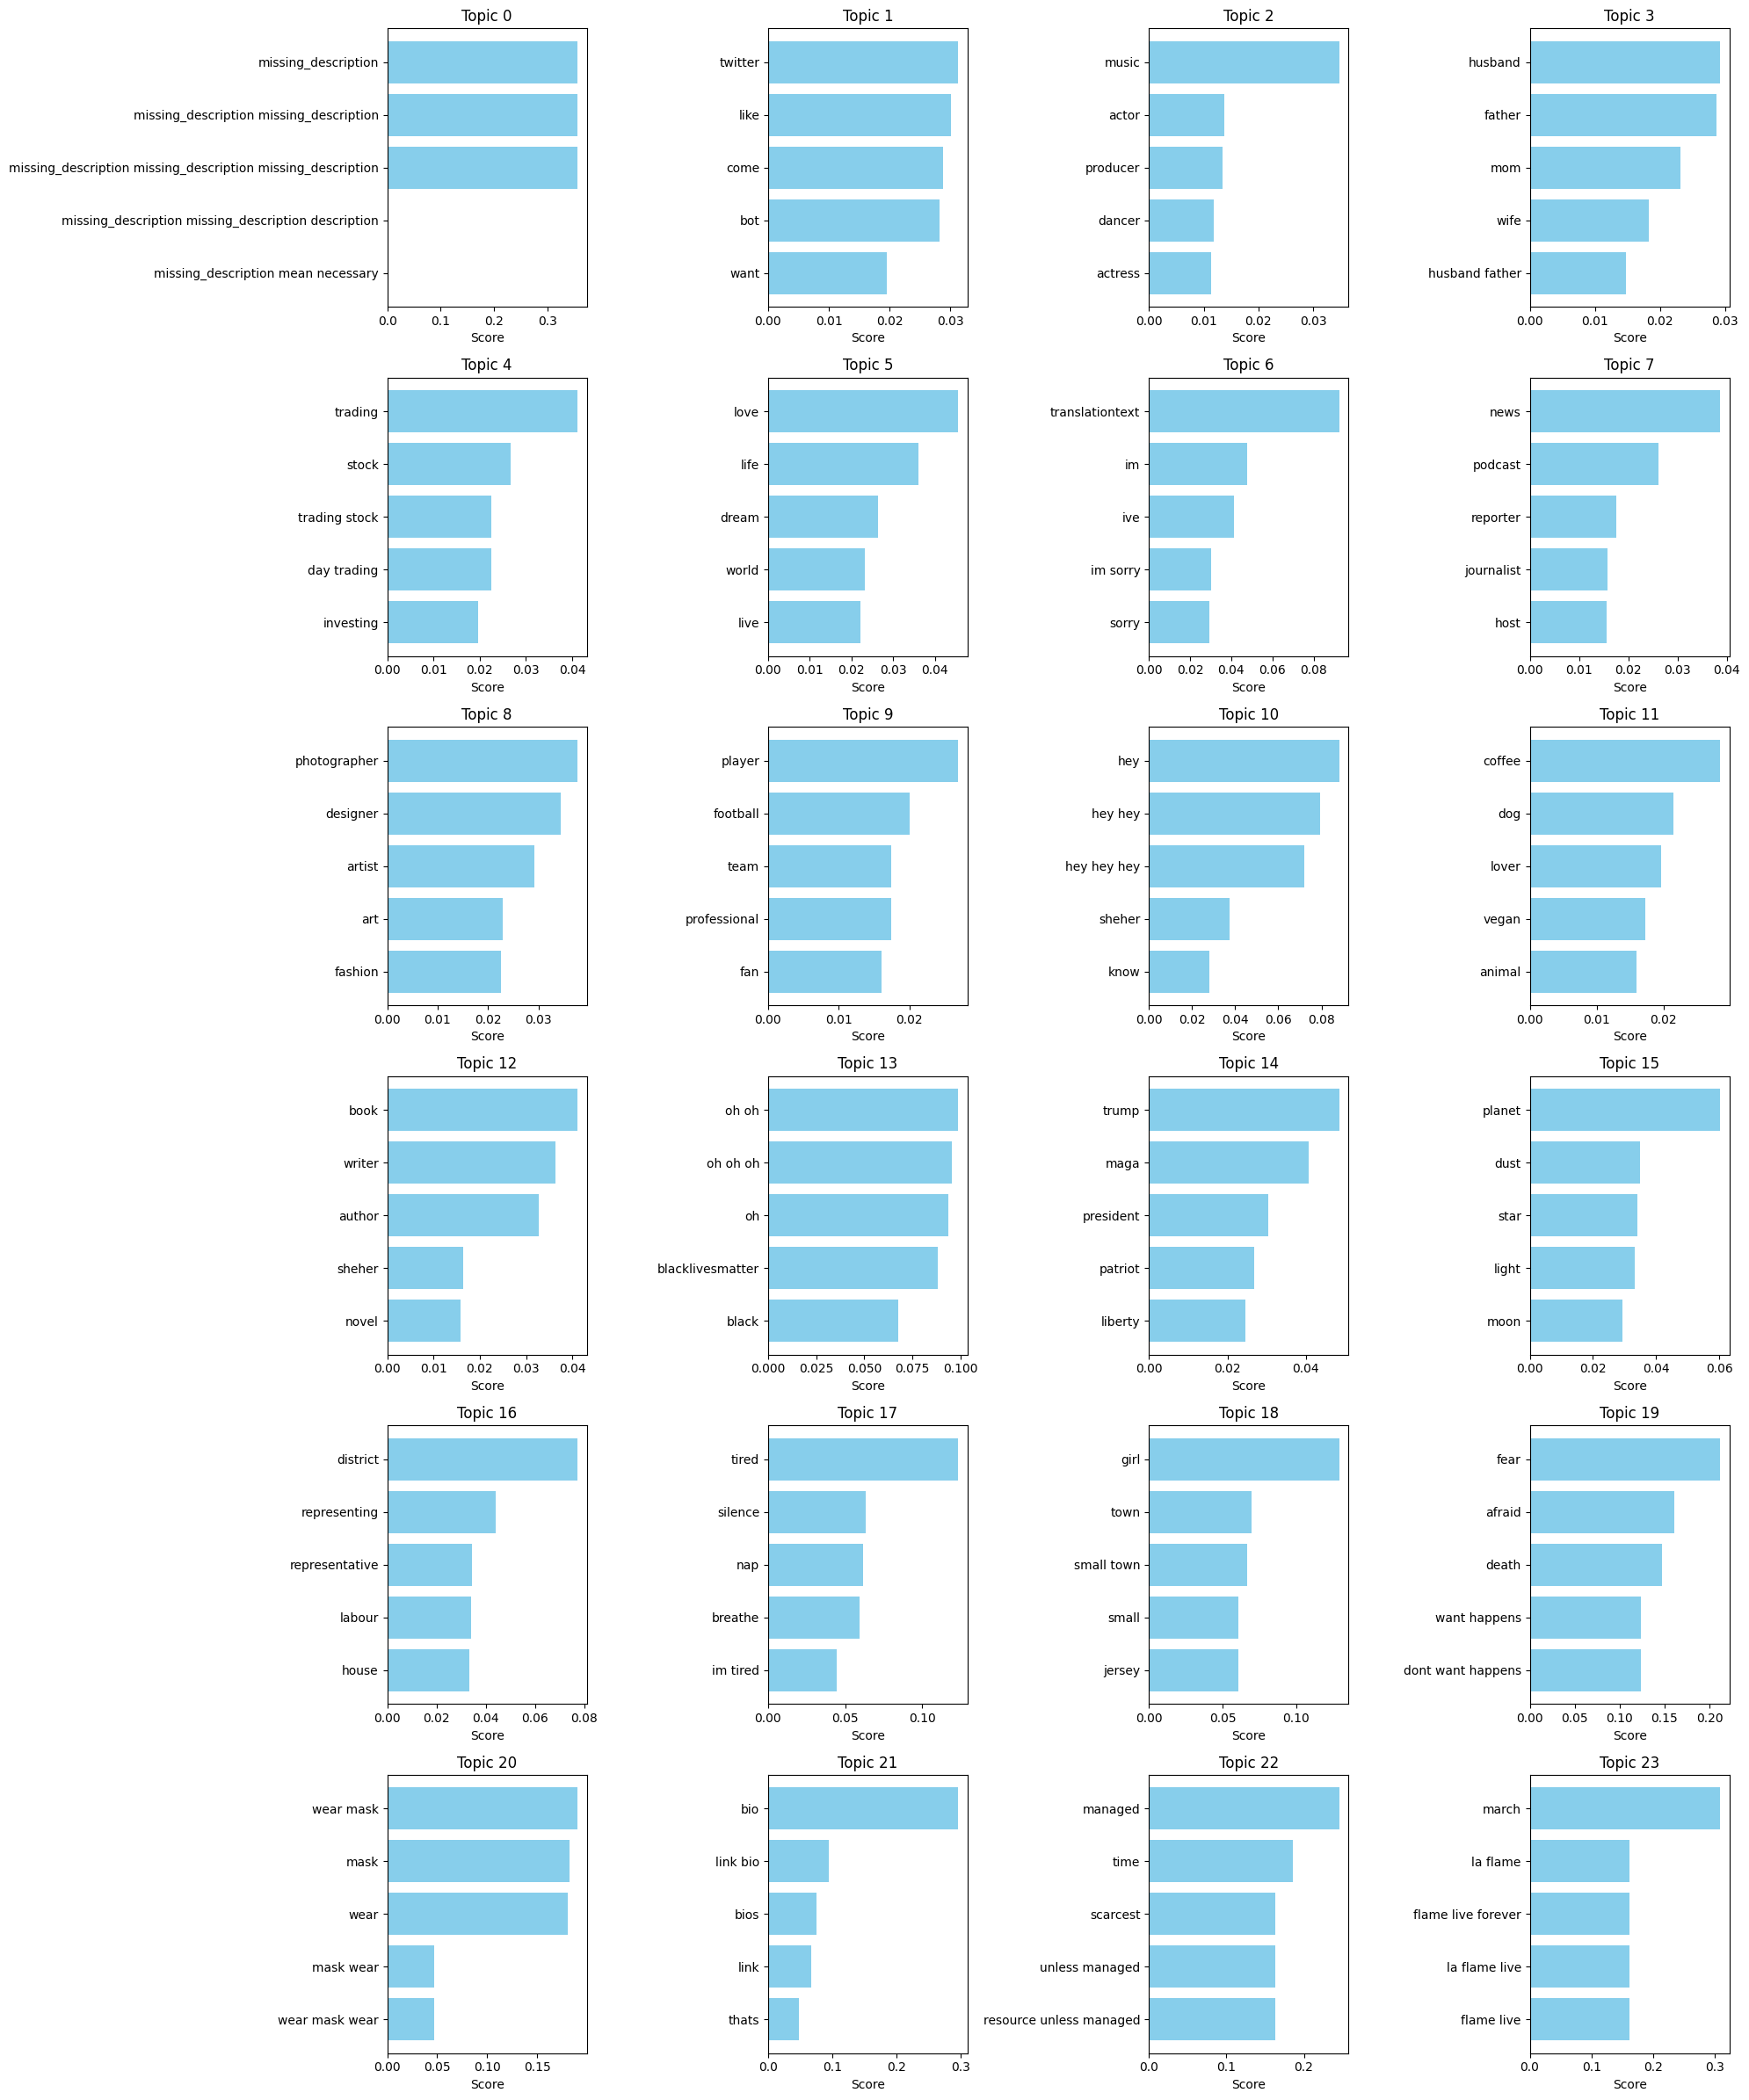

In [ ]:
import math

top_n_words = 5  # number of top words to show
topics = topic_model.get_topics()
topics_to_plot = [tid for tid in topics.keys() if tid != -1]  # skip -1

# grid size: 4 plots per row
n_cols = 4
n_rows = math.ceil(len(topics_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # flatten in case of multiple rows

for i, topic_id in enumerate(topics_to_plot):
    words_scores = topics[topic_id][:top_n_words]
    words, scores = zip(*words_scores)
    axes[i].barh(words, scores, color='skyblue')
    axes[i].set_title(f"Topic {topic_id}")
    axes[i].invert_yaxis()  # highest score on top
    axes[i].set_xlabel("Score")

# hide any unused subplots if number of topics is not divisible by n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train_bert)
test_df = pd.DataFrame(X_test_bert)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


In [21]:
# initialise model2 using logistic regression
lr_bert = LogisticRegression(max_iter=1000, class_weight='balanced')

# train on training set
lr_bert.fit(X_train_bert, y_train_bert)

# predict on validation
y_val_pred = lr_bert.predict(X_val_bert)
y_val_prob = lr_bert.predict_proba(X_val_bert)[:, 1]

# evaluate
print("LR Validation Accuracy:", accuracy_score(y_val_bert, y_val_pred))
print("LR Validation ROC-AUC:", roc_auc_score(y_val_bert, y_val_prob))
print(classification_report(y_val_bert, y_val_pred))

LR Validation Accuracy: 0.7510683760683761
LR Validation ROC-AUC: 0.8466093469829612
              precision    recall  f1-score   support

         bot       0.59      0.81      0.68      1242
       human       0.88      0.72      0.80      2502

    accuracy                           0.75      3744
   macro avg       0.74      0.76      0.74      3744
weighted avg       0.79      0.75      0.76      3744



In [22]:
# predict on test set
y_test_pred = lr_bert.predict(X_test_bert)
y_test_prob = lr_bert.predict_proba(X_test_bert)[:, 1]

print("LR Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("LR Test AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

LR Test Accuracy: 0.7526709401709402
LR Test AUC: 0.8457456920691097
              precision    recall  f1-score   support

         bot       0.59      0.80      0.68      1243
       human       0.88      0.73      0.80      2501

    accuracy                           0.75      3744
   macro avg       0.74      0.77      0.74      3744
weighted avg       0.79      0.75      0.76      3744



Top features for Logistic Regression:
                           feature  importance
31                        verified    2.474872
64                         lang_mk    1.801396
72                         lang_ru    1.570360
86                      lang_zh-cn    1.341829
57                         lang_hu    1.338095
117  description_language_gaz_Latn    1.237577
82                         lang_uk    1.230603
2                          topic_1    1.215291
30                     geo_enabled    1.120239
21                        topic_20    1.016700


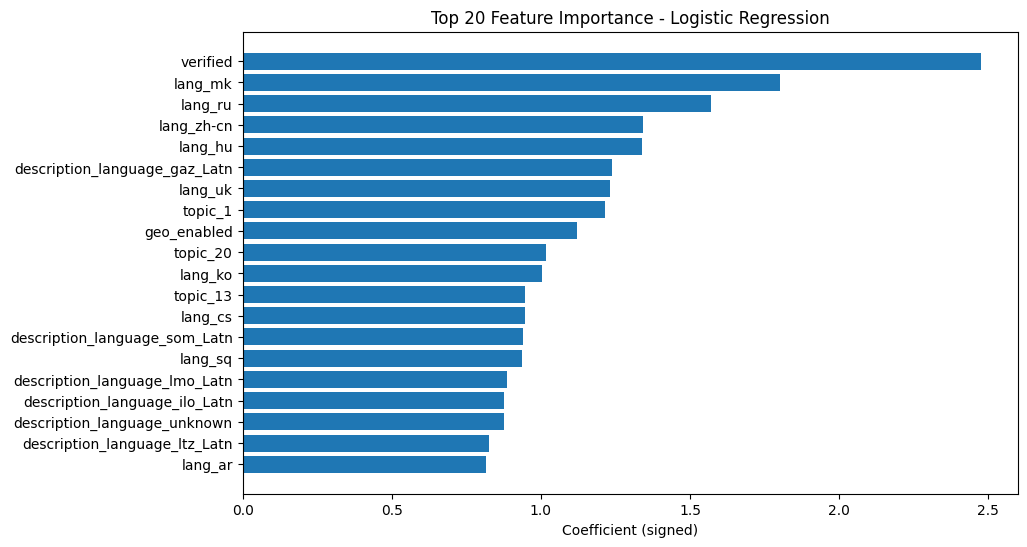

In [ ]:
# feature names (topic + tabular)
feature_names = topic_dummies_train.columns.tolist() + tabular_cols

# coefficients
lr_coef = lr_bert.coef_[0]  # binary classification

lr_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(lr_coef)
}).sort_values(by='importance', ascending=False)

print("Top features for Logistic Regression:")
print(lr_feat_importance.head(10))

# plot
plt.figure(figsize=(10,6))
plt.barh(lr_feat_importance['feature'].head(20), lr_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Logistic Regression")
plt.xlabel("Coefficient (signed)")
plt.show()

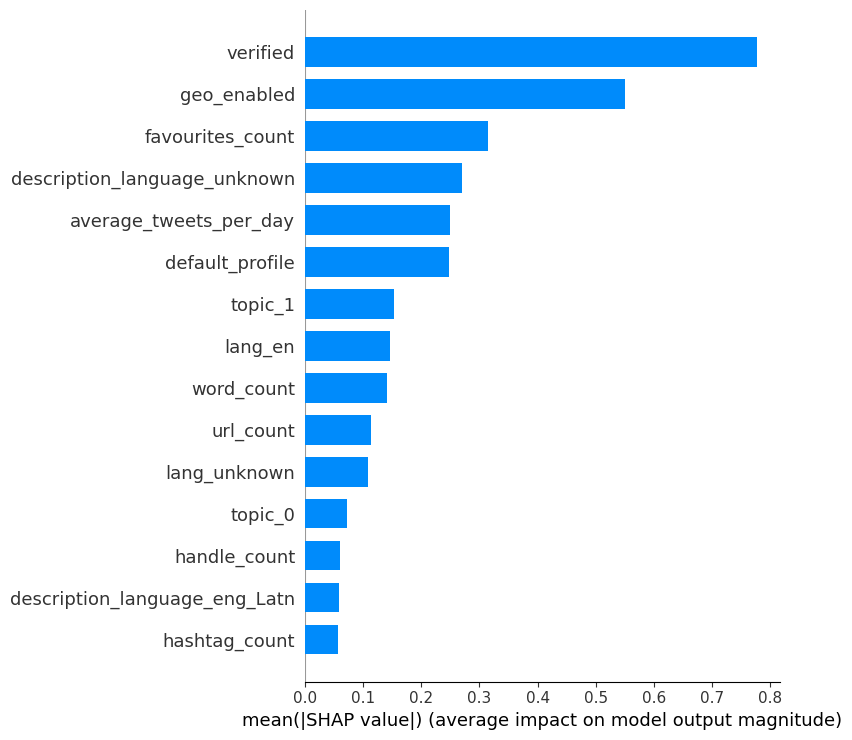

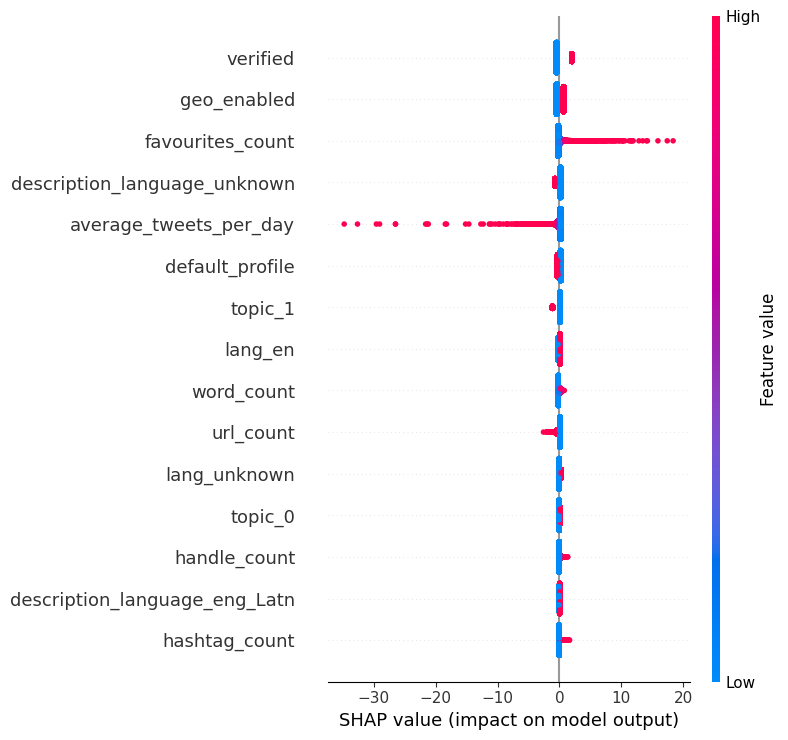

In [ ]:
explainer_lr = shap.LinearExplainer(lr_bert, X_train_bert, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_train_bert)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, plot_type="bar", max_display=15)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, max_display=15)

In [25]:
dt_bert = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)
dt_bert.fit(X_train_bert, y_train_bert)

# predict on validation set 
y_val_pred = dt_bert.predict(X_val_bert)
y_val_prob = dt_bert.predict_proba(X_val_bert)[:, 1]

print("DT Validation Accuracy:", accuracy_score(y_val_bert, y_val_pred))
print("DT Validation ROC-AUC:", roc_auc_score(y_val_bert, y_val_prob))
print(classification_report(y_val_bert, y_val_pred))


DT Validation Accuracy: 0.8306623931623932
DT Validation ROC-AUC: 0.8098448777210115
              precision    recall  f1-score   support

         bot       0.74      0.75      0.75      1242
       human       0.87      0.87      0.87      2502

    accuracy                           0.83      3744
   macro avg       0.81      0.81      0.81      3744
weighted avg       0.83      0.83      0.83      3744



In [26]:
# predict on test set 
y_test_pred = dt_bert.predict(X_test_bert)
y_test_prob = dt_bert.predict_proba(X_test_bert)[:, 1]

print("DT Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("DT Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

DT Test Accuracy: 0.8338675213675214
DT Test ROC-AUC: 0.8119149765676996
              precision    recall  f1-score   support

         bot       0.75      0.75      0.75      1243
       human       0.87      0.88      0.88      2501

    accuracy                           0.83      3744
   macro avg       0.81      0.81      0.81      3744
weighted avg       0.83      0.83      0.83      3744



Top features for Decision Tree:
                        feature  importance
28              followers_count    0.332843
27             favourites_count    0.128034
32       average_tweets_per_day    0.110664
33             account_age_days    0.096137
29                friends_count    0.093255
39  log_followers_friends_ratio    0.048276
35             mean_word_length    0.028595
34                   word_count    0.027446
31                     verified    0.027341
30                  geo_enabled    0.013561


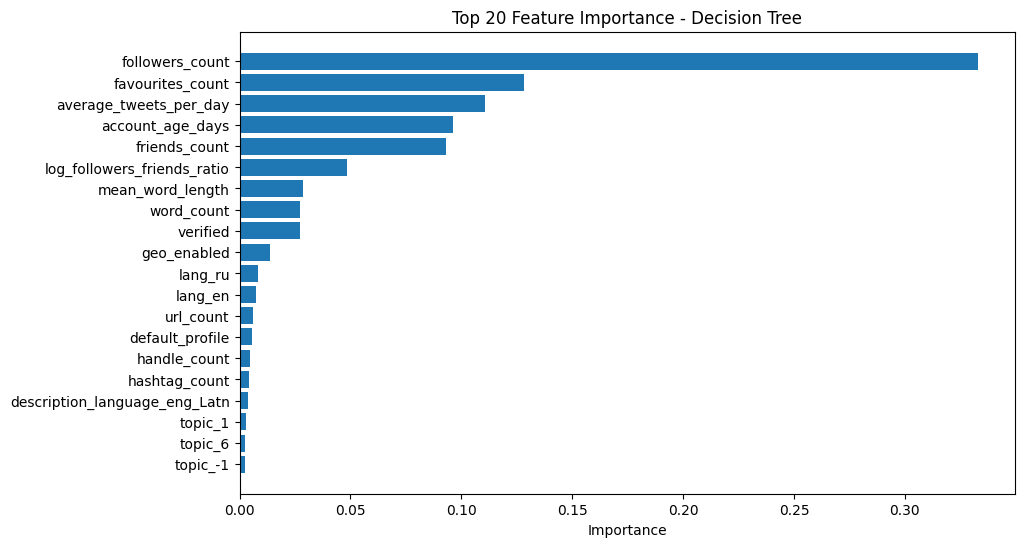

In [ ]:
# decision tree feature importance
dt_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Decision Tree:")
print(dt_feat_importance.head(10))

# plot
plt.figure(figsize=(10,6))
plt.barh(dt_feat_importance['feature'].head(20), dt_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.show()

In [28]:
X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

explainer_dt = shap.TreeExplainer(dt_bert)
shap_values_dt = explainer_dt.shap_values(X_train_df)

print(type(shap_values_dt))
if isinstance(shap_values_dt, list):
    print([s.shape for s in shap_values_dt])
else:
    print(shap_values_dt.shape)
print("X_train_df shape:", X_train_df.shape)

<class 'numpy.ndarray'>
(29950, 208, 2)
X_train_df shape: (29950, 208)


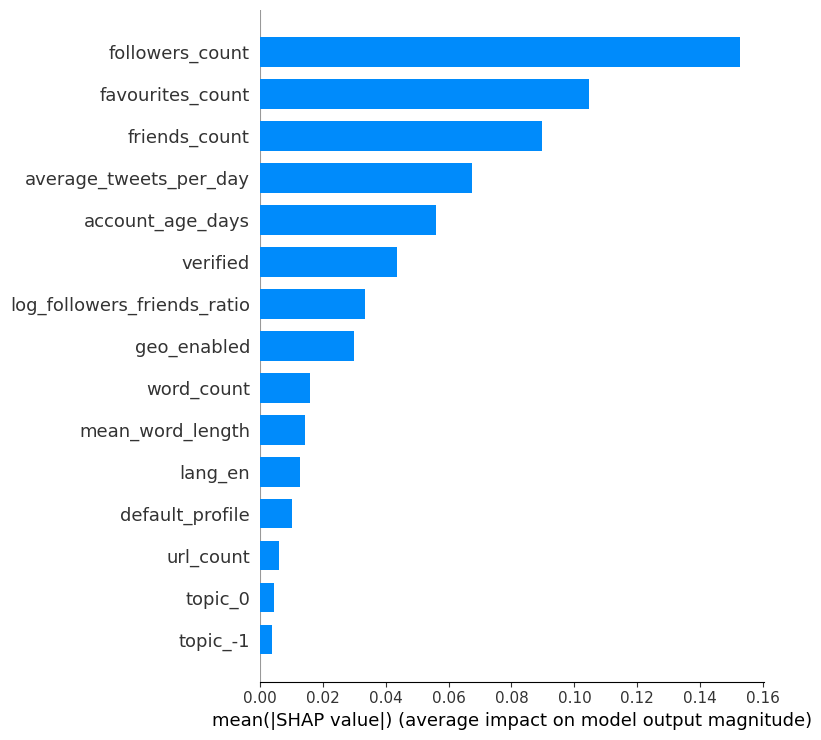

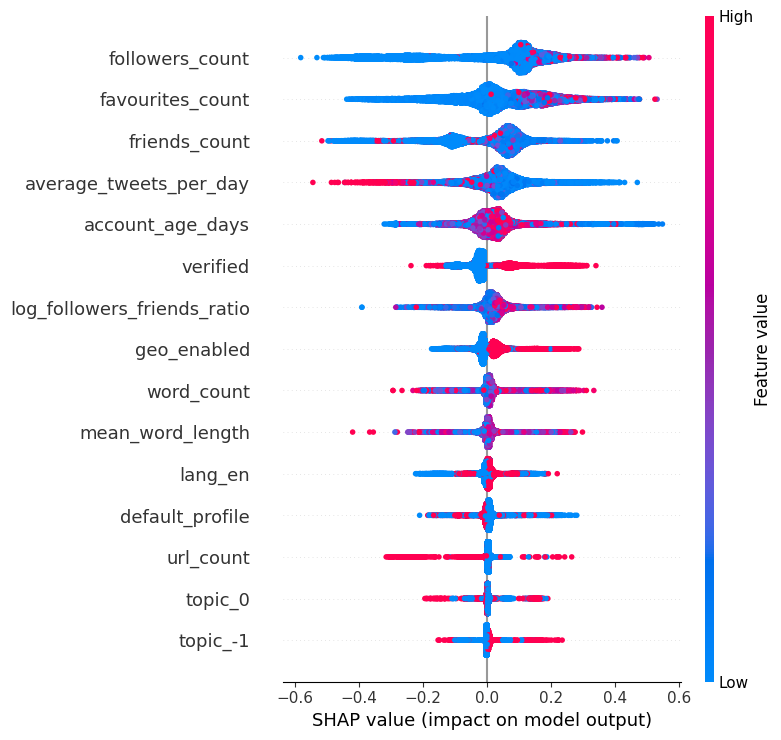

In [ ]:
shap_values_class1 = shap_values_dt[:, :, 1]
shap.summary_plot(shap_values_class1, X_train_df, plot_type="bar", max_display=15)
shap.summary_plot(shap_values_class1, X_train_df, max_display=15)

In [30]:
rf_bert = RandomForestClassifier(n_estimators=200, max_depth=None, class_weight='balanced', random_state=42)
rf_bert.fit(X_train_bert, y_train_bert)

# predict on validation set 
y_val_pred = rf_bert.predict(X_val_bert)
y_val_prob = rf_bert.predict_proba(X_val_bert)[:, 1]

print("RF Validation Accuracy:", accuracy_score(y_val_bert, y_val_pred))
print("RF Validation ROC-AUC:", roc_auc_score(y_val_bert, y_val_prob))
print(classification_report(y_val_bert, y_val_pred))


RF Validation Accuracy: 0.875
RF Validation ROC-AUC: 0.9318126818995689
              precision    recall  f1-score   support

         bot       0.86      0.74      0.80      1242
       human       0.88      0.94      0.91      2502

    accuracy                           0.88      3744
   macro avg       0.87      0.84      0.85      3744
weighted avg       0.87      0.88      0.87      3744



In [31]:
# predict on test set
y_test_pred = rf_bert.predict(X_test_bert)
y_test_prob = rf_bert.predict_proba(X_test_bert)[:, 1]

print("RF Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("RF Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

RF Test Accuracy: 0.874732905982906
RF Test ROC-AUC: 0.9302780898903513
              precision    recall  f1-score   support

         bot       0.87      0.74      0.80      1243
       human       0.88      0.94      0.91      2501

    accuracy                           0.87      3744
   macro avg       0.87      0.84      0.85      3744
weighted avg       0.87      0.87      0.87      3744



Top features for Random Forest:
                        feature  importance
28              followers_count    0.147936
27             favourites_count    0.133393
29                friends_count    0.117318
32       average_tweets_per_day    0.102302
33             account_age_days    0.084597
39  log_followers_friends_ratio    0.080974
35             mean_word_length    0.047206
34                   word_count    0.038115
30                  geo_enabled    0.036480
31                     verified    0.035541


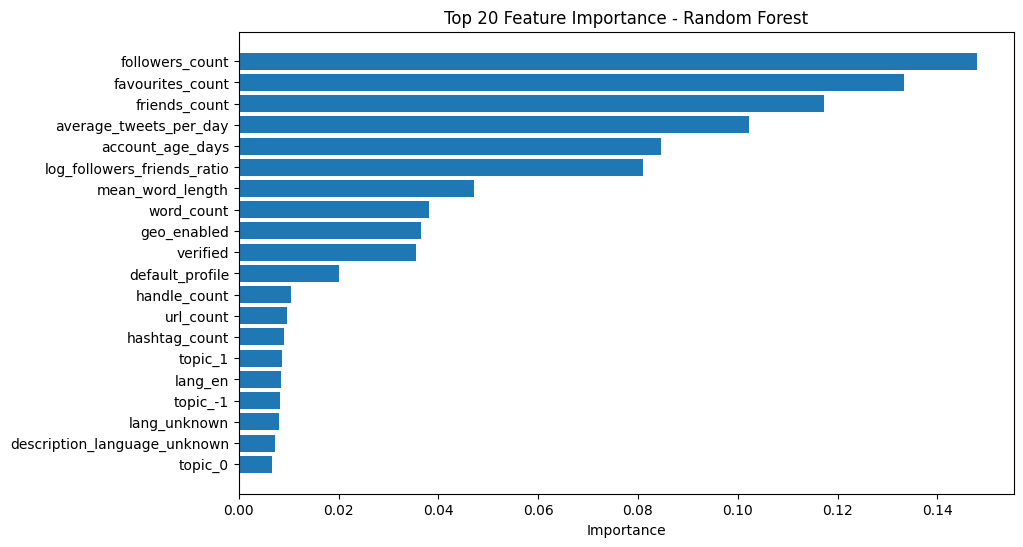

In [ ]:
# random forest feature importance
rf_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Random Forest:")
print(rf_feat_importance.head(10))

# plot
plt.figure(figsize=(10,6))
plt.barh(rf_feat_importance['feature'].head(20), rf_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.show()

In [ ]:
X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

explainer_rf = shap.TreeExplainer(rf_bert)
shap_values_rf = explainer_rf.shap_values(X_train_df)

print(type(shap_values_rf))
print(np.array(shap_values_rf).shape)

shap_values_rf_class1 = shap_values_rf[:, :, 1]

shap.summary_plot(shap_values_rf_class1, X_train_df, plot_type="bar", max_display=15)
shap.summary_plot(shap_values_rf_class1, X_train_df, max_display=15)